## Demonstration of Spoken Digits Classification

This jupyter notebook is part of a [collection of notebooks](../index.ipynb) on various topics of Data-Driven Signal Processing. Please direct questions and suggestions to [Sascha.Spors@uni-rostock.de](mailto:Sascha.Spors@uni-rostock.de).

This notebook demonstrates the classification of recorded spoken digits in the [Free Spoken Digit Dataset](https://github.com/Jakobovski/free-spoken-digit-dataset) (FSDD). Please download/clone the dataset before executing this notebook. Mel-Frequency Cepstral Coefficients (MFCCs) are used as features which are fed into a deep neural network (DNN) for classification.

In [1]:
import os
import glob

import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf

from librosa.feature import mfcc

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
path = '../data/free-spoken-digit-dataset/recordings/'  # path to dataset

### Load Dataset

The FSDD consists of a series of wav files containing recordings of the single spoken digits `0-9` for different individuals. Each digit has been recorded multiple times for each individual. In the following, all samples in the database are loaded, normalized and truncated to a common length.

In [3]:
def load_examples(path):

    X = list()
    Y = list()

    audiofiles = glob.glob(path, recursive=True)
    for filepath in audiofiles:
        x, fs = sf.read(filepath)
        x = x / np.max(np.abs(x))
        X.append(x)
        Y.append(int(os.path.basename(filepath)[0]))

    return X, Y, fs


# load examples
X_raw, Y, fs = load_examples(path + '*.wav')

# determine maximum length of the examples
lengths = [len(x) for x in X_raw]
F = np.max(lengths)

# append zeros to examples to equalize lengths
X_raw = [np.concatenate((sample, np.zeros(F - len(sample))))
         for sample in X_raw]
X_raw = np.array(X_raw)
Y = np.array(Y)

# one-hot encoding of class labels
Y1h = to_categorical(Y, 10)

In [4]:
print('Total number of examples: {}'.format(len(X_raw)))
print('Number of samples per example: {}'.format(F))

Total number of examples: 3000
Number of samples per example: 18262


### Feature Extraction

Now the MFCCs for each example are computed.

In [5]:
X = [mfcc(y=sample, sr=fs, htk=True) for sample in X_raw]
X = np.array(X)
X = X.reshape((-1, np.prod(X.shape[1:])))

print('Total number of examples: {}'.format(X.shape[0]))
print('Dimension of feature vectors: {}'.format(X.shape[1]))

Total number of examples: 3000
Dimension of feature vectors: 720


### Define and Train the Model

The model is defined as a concatenation of an input layer, hidden layers, dropout layers, and an output layer. For the model, the output shapes of the individual layers, as well as the number of parameters that have to be determined in the training phase are summarized.

In [6]:
def dnn_model(input_shape=(720,), classes=10):

    inputs = Input(shape=input_shape)

    x = Dense(64, activation='relu')(inputs)
    x = Dropout(0.1)(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.1)(x)
    x = Dense(classes, activation='softmax')(x)

    return Model(inputs, x)


model = dnn_model()
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 720)]             0         
_________________________________________________________________
dense (Dense)                (None, 64)                46144     
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                650       
Total params: 50,954
Trainable params: 50,954
Non-trainable params: 0
_________________________________________________________

2022-01-06 15:05:32.429911: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2022-01-06 15:05:32.430291: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 8. Tune using inter_op_parallelism_threads for best performance.


Now the model is compiled and trained. We used the `categorical crossentropy` as loss and the `Adam` optimizer. As evaluation metrics, the accuracy of the prediction is used. The examples are split into a set of examples used for training and a set used for validation of the trained model. The loss and the accuracy is plotted for each epoch for both the training and validation subsets. Early stopping is used to prevent overfitting of the model.

In [7]:
model.compile(loss="categorical_crossentropy",
              optimizer="adam", metrics=["accuracy"])

X_train, X_test, Y_train, Y_test = train_test_split(X, Y1h, test_size=0.2)

callback = EarlyStopping(monitor='accuracy', patience=15)
history = model.fit(X_train, Y_train, validation_data=(
    X_test, Y_test), callbacks=[callback], epochs=100, batch_size=128)

Train on 2400 samples, validate on 600 samples
Epoch 1/100
2400/2400 [==============================] - 1s 411us/sample - loss: 62.1576 - accuracy: 0.1150 - val_loss: 9.3773 - val_accuracy: 0.2000
Epoch 2/100
2400/2400 [==============================] - 0s 69us/sample - loss: 12.9014 - accuracy: 0.1746 - val_loss: 4.8118 - val_accuracy: 0.1817
Epoch 3/100
2400/2400 [==============================] - 0s 71us/sample - loss: 3.8486 - accuracy: 0.2108 - val_loss: 2.3508 - val_accuracy: 0.1833
Epoch 4/100
2400/2400 [==============================] - 0s 65us/sample - loss: 2.3335 - accuracy: 0.1221 - val_loss: 2.2267 - val_accuracy: 0.1233
Epoch 5/100
2400/2400 [==============================] - 0s 67us/sample - loss: 2.1977 - accuracy: 0.1429 - val_loss: 2.0769 - val_accuracy: 0.1933
Epoch 6/100
2400/2400 [==============================] - 0s 68us/sample - loss: 2.0769 - accuracy: 0.1971 - val_loss: 2.0229 - val_accuracy: 0.2733
Epoch 7/100
2400/2400 [==============================] - 0s 71

Epoch 56/100
2400/2400 [==============================] - 0s 66us/sample - loss: 0.5010 - accuracy: 0.8413 - val_loss: 0.4020 - val_accuracy: 0.8717
Epoch 57/100
2400/2400 [==============================] - 0s 67us/sample - loss: 0.4938 - accuracy: 0.8304 - val_loss: 0.3819 - val_accuracy: 0.9017
Epoch 58/100
2400/2400 [==============================] - 0s 67us/sample - loss: 0.4552 - accuracy: 0.8442 - val_loss: 0.2960 - val_accuracy: 0.9200
Epoch 59/100
2400/2400 [==============================] - 0s 69us/sample - loss: 0.4493 - accuracy: 0.8550 - val_loss: 0.3333 - val_accuracy: 0.8967
Epoch 60/100
2400/2400 [==============================] - 0s 68us/sample - loss: 0.4915 - accuracy: 0.8313 - val_loss: 0.4024 - val_accuracy: 0.8700
Epoch 61/100
2400/2400 [==============================] - 0s 68us/sample - loss: 0.4806 - accuracy: 0.8392 - val_loss: 0.3235 - val_accuracy: 0.9017
Epoch 62/100
2400/2400 [==============================] - 0s 68us/sample - loss: 0.4171 - accuracy: 0.8671

### Evaluation of the Model

First we take a look at the evolution of the loss and the accuracy over the epochs

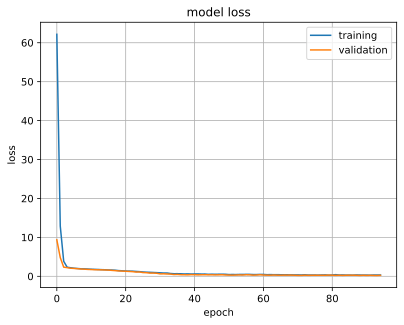

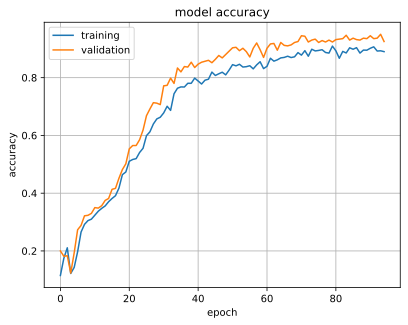

In [8]:
def plot_history(history, key):
    plt.figure()
    plt.plot(history.history[key], label='training')
    plt.plot(history.history[f'val_{key}'], label='validation')
    plt.title(f'model {key}')
    plt.ylabel(key)
    plt.xlabel('epoch')
    plt.legend()
    plt.grid()


plot_history(history, 'loss')
plot_history(history, 'accuracy')

The performance of the trained classifier on the validation examples is summarized in the classification report including various performance metrics

In [9]:
Y_pred = model.predict(X_test)
print(classification_report(np.argmax(Y_test, axis=1), np.argmax(Y_pred, axis=1)))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98        46
           1       1.00      0.83      0.91        70
           2       0.93      0.92      0.93        61
           3       0.82      0.95      0.88        62
           4       1.00      1.00      1.00        66
           5       0.90      0.98      0.94        54
           6       0.94      0.88      0.91        58
           7       0.86      0.95      0.90        58
           8       0.95      0.90      0.92        68
           9       0.89      0.89      0.89        57

    accuracy                           0.93       600
   macro avg       0.93      0.93      0.93       600
weighted avg       0.93      0.93      0.93       600



**Copyright**

This notebook is provided as [Open Educational Resource](https://de.wikipedia.org/wiki/Open_Educational_Resources).
The text is licensed under [Creative Commons Attribution 4.0](https://creativecommons.org/licenses/by/4.0/)
, the code of the IPython examples under the [MIT license](https://opensource.org/licenses/MIT). Please attribute the work as follows: Sascha Spors, Data driven audio signal processing - Lecture supplementals.